In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

engine


Engine(sqlite:///Resources/hawaii.sqlite)

In [8]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Inspect the hawaii data base

In [11]:
from sqlalchemy import inspect
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
from sqlalchemy import inspect
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [47]:
# Calculate the date 1 year ago from the last data point in the database
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest

('2017-08-23')

In [65]:
# Perform a query to retrieve the data and precipitation scores

precip_last_year = session.query(Measurement.date,Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').\
                    order_by(Measurement.date).all()
precip_last_year

precip_df = pd.DataFrame(precip_last_year, columns=['Date', 'Precip'])

precip_df = precip_df.dropna()
#precip_df.head()
#precip_df.set_index("Date", inplace = True)
#precip_df.head(20)

#precip_df['Date'] = pd.to_datetime(precip_df['Date'])
precip_df = precip_df.set_index('Date')

#precip_df['Precip'].count()
precip_df.head()


,Precip
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


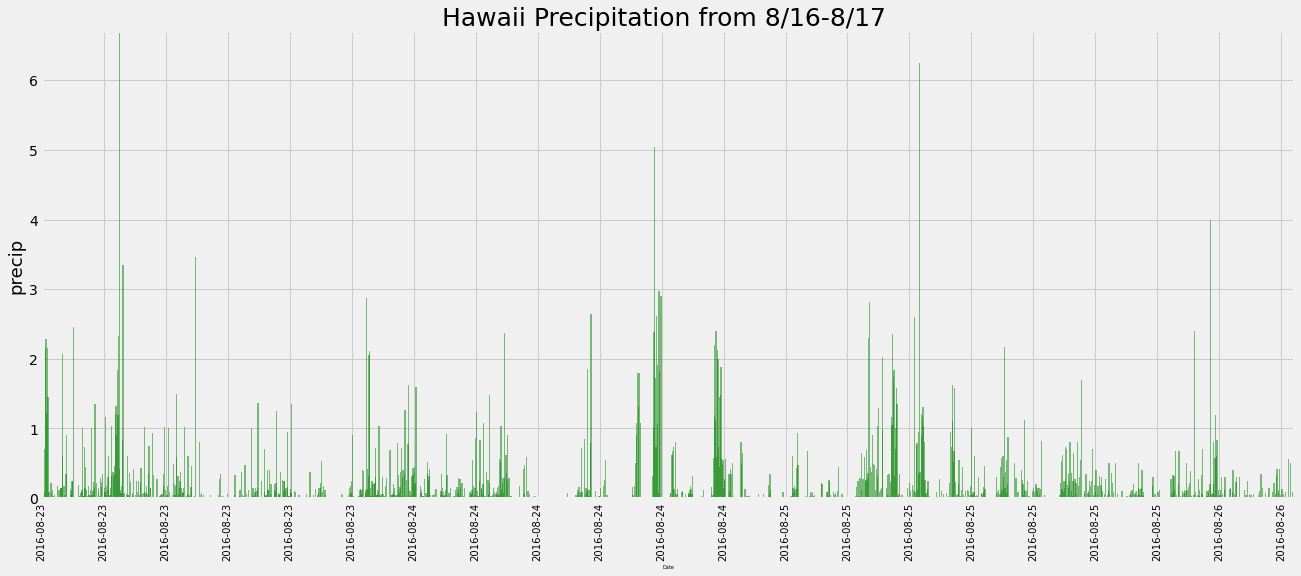

In [73]:
df = precip_df
labels = df.index

# Set x axis and tick locations
x_axis = np.arange(len(labels))
tick_locations = [value+0.2 for value in x_axis]

#set fig size, x-axis, y
plt.figure(figsize=(20,8))
width = 2

#plot  data
plt.bar(x_axis - width, df['Precip'],width = width, color='g', alpha=0.5, align="edge", label = 'precip(in)')
#plt.xticks(tick_locations, df.index, rotation="vertical", fontsize=16)
major_ticks = np.arange(0,2021,100)
plt.xticks(major_ticks, df.index, rotation="vertical", fontsize = 10)

# Set x and y limits
plt.xlim(-0.25, len(x_axis))
plt.ylim(0, max(df["Precip"]))

# Set Title and labels
plt.title("Hawaii Precipitation from 8/16-8/17 ", fontdict = {'fontsize' : 25})
plt.xlabel("Date", fontdict = {'fontsize' : 5})
plt.ylabel("precip",  fontdict = {'fontsize' : 18})

plt.show()




In [74]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [86]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.name).count()

print(f"the are {stations} stations")



the are 9 stations


In [92]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# List the stations and the counts in descending order.
active_list = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

active_list

most_active = active_list[0][0]
most_active



'USC00519281'

In [115]:
# Using the station id from the previous query, calculate the lowest temperature recorded, # highest temperature recorded, 
#and average temperature of the most active station?

low = session.query(func.min(Measurement.tobs).filter(Measurement.station == most_active)).all()[0][0]
avg = round(session.query(func.avg(Measurement.tobs).filter(Measurement.station == most_active)).all()[0][0],2)
hi = session.query(func.max(Measurement.tobs).filter(Measurement.station == most_active)).all()[0][0]

print (f"low temp = {low}")
print (f"avg temp = {avg}")
print (f"high temp = {hi}")






low temp = 54.0
avg temp = 71.66
high temp = 85.0


In [124]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point in the database
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest)

twelve_months_ago = dt.datetime.strptime(latest[0], '%Y-%m-%d') - dt.timedelta(days=365)
twelve_months_ago

last_twelve_temps = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date >= twelve_months_ago).all()


#make pd_df for plotting
temps_df = pd.DataFrame(last_twelve_temps)

temps_df.head(20)





('2017-08-23',)


,station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
5,USC00519281,78.0
6,USC00519281,77.0
7,USC00519281,78.0
8,USC00519281,80.0
9,USC00519281,80.0


In [ ]:
station_name = session.query(Station.name).filter(Station.id == USC00519281).all()
station_name

#last_twelve_temps = session.query(Measurement.station, Measurement.tobs).\
#                filter(Measurement.station == most_active).\
#                filter(Measurement.date >= twelve_months_ago).all()

In [156]:
active_station = session.query(Station.name).filter(Station.station == most_active).all()[0][0]
active_station


'WAIHEE 837.5, HI US'

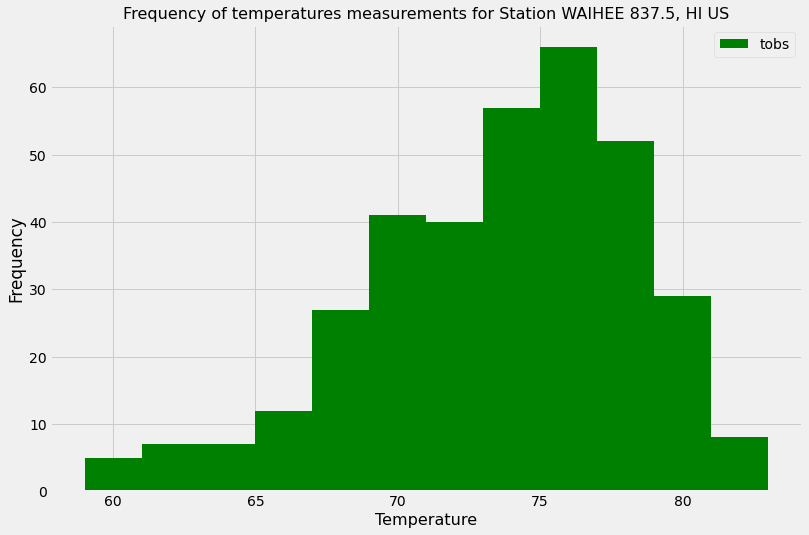

In [165]:
# Plot the results as a histogram with bins=12.
temps_df.plot.hist(by='station', bins=12, figsize=(12,8), color="green")
plt.title("Frequency of temperatures measurements for Station " + active_station, fontsize=16)
plt.xlabel("Temperature", fontsize=16)
plt.savefig("station_emps.png")
plt.show()